In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the preprocessed data
df = pd.read_csv('/Users/gillianmondero/marketing_summary_cleaned.csv')

# Data Understanding
# Convert date column to datetime objects
df['date'] = pd.to_datetime(df['date'])

# Display basic info and check for nulls
print("Data Info:")
df.info()
print("\nDescriptive Statistics:")
print(df.describe())

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1234 entries, 0 to 1233
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              1234 non-null   datetime64[ns]
 1   users_active      1234 non-null   int64         
 2   total_sales       1234 non-null   float64       
 3   new_customers     1234 non-null   int64         
 4   report_generated  1234 non-null   object        
 5   region            1234 non-null   object        
 6   regional_sales    1234 non-null   float64       
 7   product_id        1234 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 77.3+ KB

Descriptive Statistics:
                                date  users_active   total_sales  \
count                           1234   1234.000000   1234.000000   
mean   2023-07-20 02:23:31.993517056    271.820097  58067.223995   
min              2023-06-01 00:0

In [4]:
# Aggregation for Daily Analysis 
# Since daily metrics are repeated, we need a daily summary view.
# We'll group by date and take the first value for daily columns, and sum regional sales.
daily_summary = df.groupby('date').agg(
    users_active=('users_active', 'first'),
    total_sales=('total_sales', 'first'),
    new_customers=('new_customers', 'first')
).reset_index()

print("\nAggregated Daily Summary:")
print(daily_summary.head())


Aggregated Daily Summary:
        date  users_active  total_sales  new_customers
0 2023-06-01           179     81287.31              9
1 2023-06-02            67     74771.99              5
2 2023-06-03           369     84809.74             11
3 2023-06-04            94     61212.30              3
4 2023-06-05           402     80911.49             10


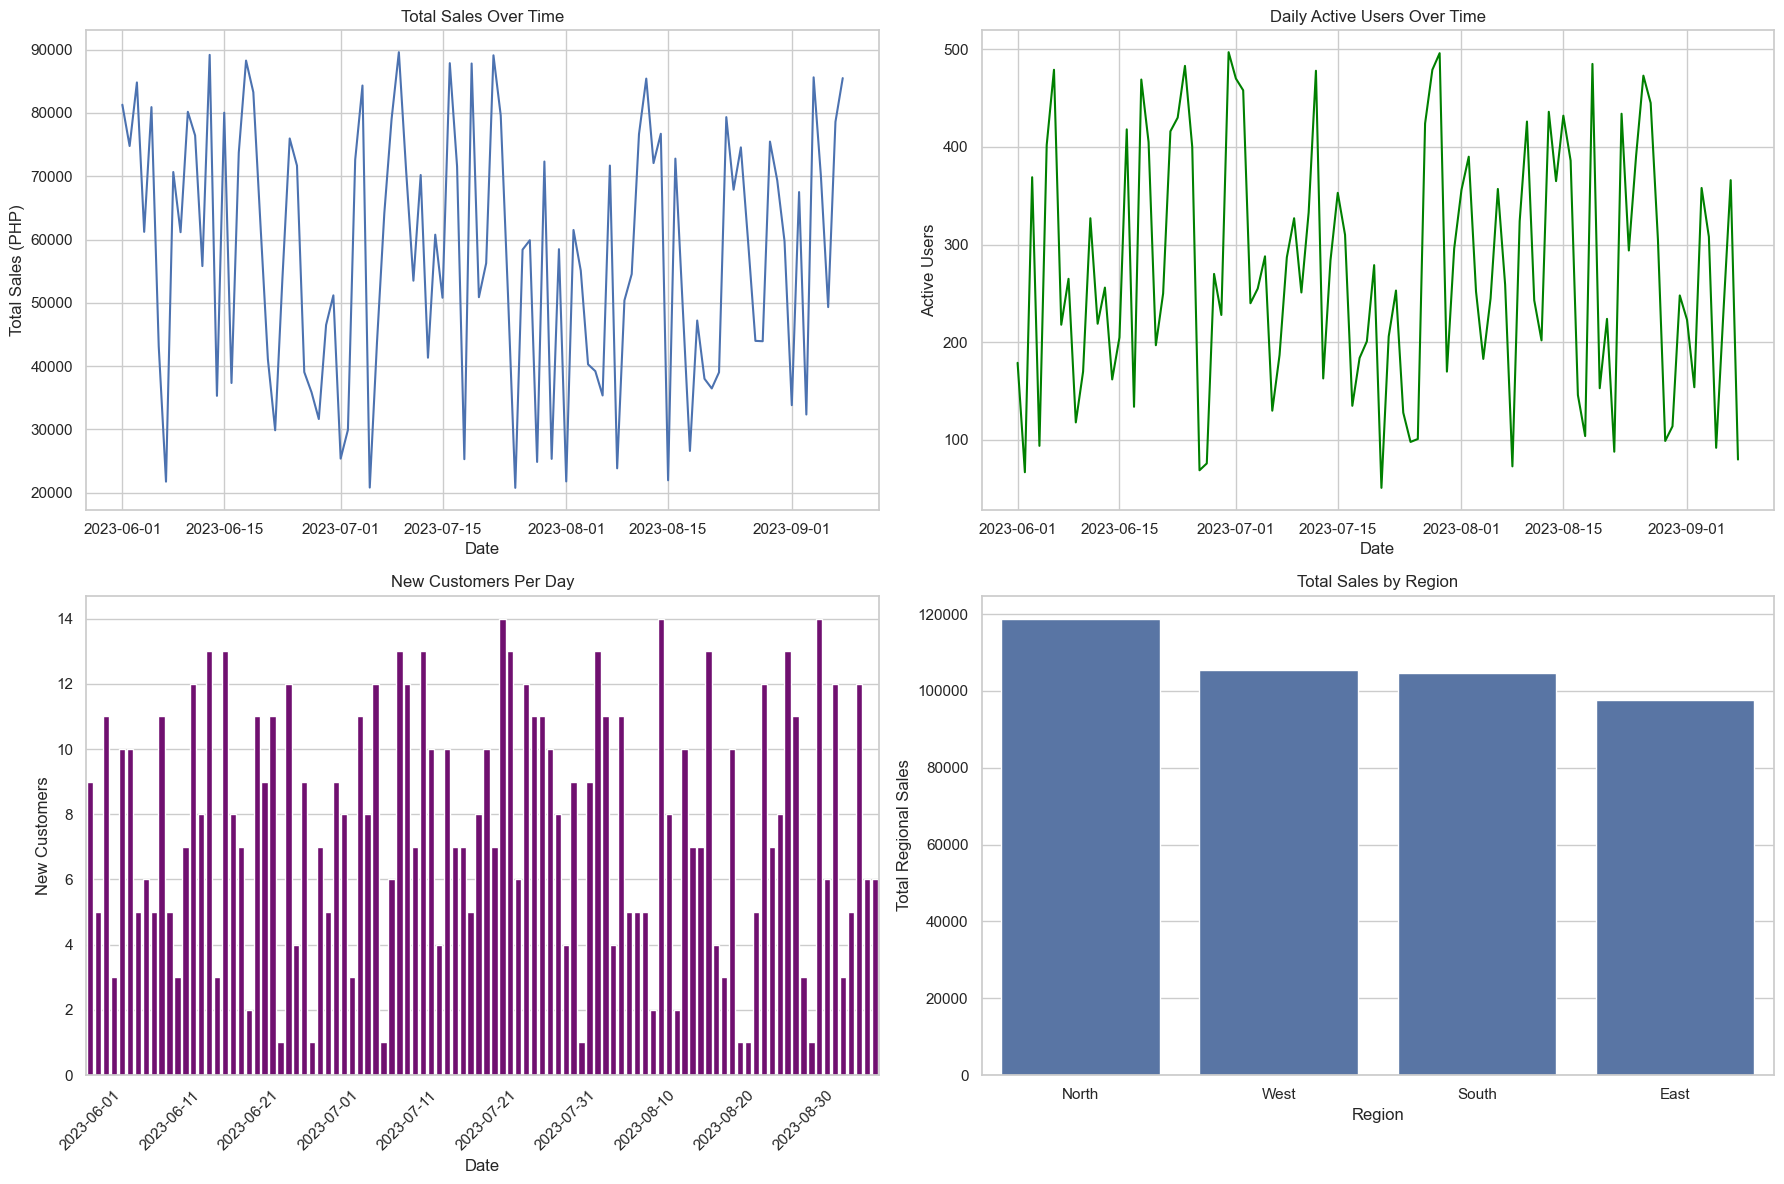

In [7]:
# Visualizations
# Set up the plotting style
sns.set(style="whitegrid")
plt.figure(figsize=(18, 12))

# 1. Total Sales Over Time
plt.subplot(2, 2, 1)
sns.lineplot(data=daily_summary, x='date', y='total_sales')
plt.title('Total Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales (PHP)')

# 2. Daily Active Users Over Time
plt.subplot(2, 2, 2)
sns.lineplot(data=daily_summary, x='date', y='users_active', color='green')
plt.title('Daily Active Users Over Time')
plt.xlabel('Date')
plt.ylabel('Active Users')

# 3. New Customers Per Day
plt.subplot(2, 2, 3)
sns.barplot(data=daily_summary, x='date', y='new_customers', color='purple')
plt.title('New Customers Per Day')
plt.xlabel('Date')
plt.ylabel('New Customers')
# Make x-axis labels more readable
plt.xticks(rotation=45)
# Display fewer ticks on the x-axis for the bar plot
ax = plt.gca()
ax.xaxis.set_major_locator(plt.MaxNLocator(10)) 

# 4. Total Sales by Region
plt.subplot(2, 2, 4)
regional_sales = df.groupby('region')['regional_sales'].sum().sort_values(ascending=False)
sns.barplot(x=regional_sales.index, y=regional_sales.values)
plt.title('Total Sales by Region')
plt.xlabel('Region')
plt.ylabel('Total Regional Sales')

plt.tight_layout()
plt.show()

In [8]:
# Feature Engineering
# Feature 1: Time-Based Features
daily_summary['day_of_week'] = daily_summary['date'].dt.day_name()
daily_summary['month'] = daily_summary['date'].dt.month
print("\nDaily summary with time features:")
print(daily_summary.head())


Daily summary with time features:
        date  users_active  total_sales  new_customers day_of_week  month
0 2023-06-01           179     81287.31              9    Thursday      6
1 2023-06-02            67     74771.99              5      Friday      6
2 2023-06-03           369     84809.74             11    Saturday      6
3 2023-06-04            94     61212.30              3      Sunday      6
4 2023-06-05           402     80911.49             10      Monday      6


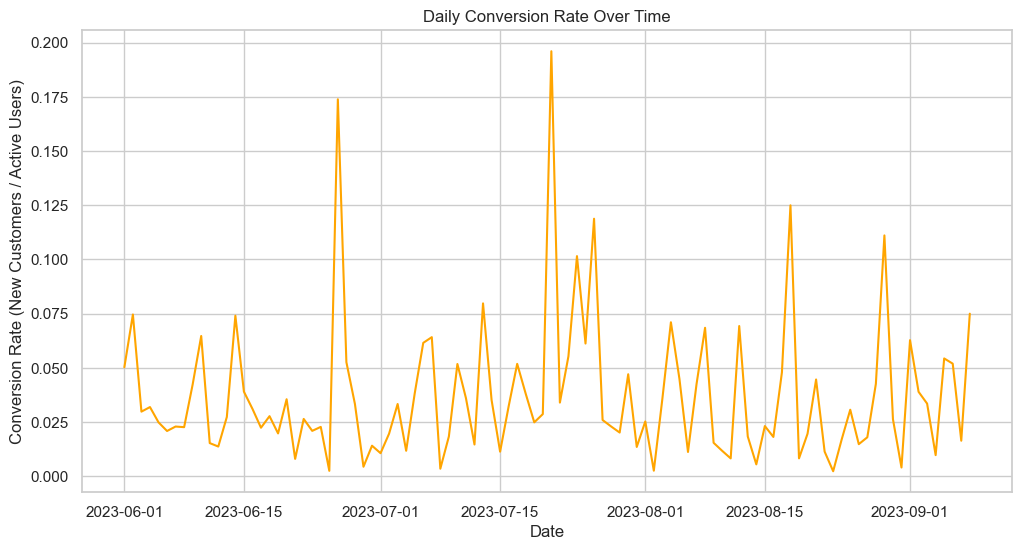


Daily summary with conversion rate:
        date  users_active  total_sales  new_customers day_of_week  month  \
0 2023-06-01           179     81287.31              9    Thursday      6   
1 2023-06-02            67     74771.99              5      Friday      6   
2 2023-06-03           369     84809.74             11    Saturday      6   
3 2023-06-04            94     61212.30              3      Sunday      6   
4 2023-06-05           402     80911.49             10      Monday      6   

   conversion_rate  
0         0.050279  
1         0.074627  
2         0.029810  
3         0.031915  
4         0.024876  


In [11]:
# Feature 2: Conversion Rate
# Formula: (New Customers / Active Users)
# Handle cases where active users might be 0 to avoid division by zero errors.
daily_summary['conversion_rate'] = daily_summary.apply(
    lambda row: row['new_customers'] / row['users_active'] if row['users_active'] > 0 else 0,
    axis=1
)

# Visualize Conversion Rate
plt.figure(figsize=(12, 6))
sns.lineplot(data=daily_summary, x='date', y='conversion_rate', color='orange')
plt.title('Daily Conversion Rate Over Time')
plt.ylabel('Conversion Rate (New Customers / Active Users)')
plt.xlabel('Date')
plt.show()
print("\nDaily summary with conversion rate:")
print(daily_summary.head())

In [13]:
# Feature 3: Region-based performance
region_features = df.groupby('region').agg(
    total_regional_sales=('regional_sales', 'sum'),
    avg_daily_sales=('regional_sales', 'mean'),
    days_with_sales=('regional_sales', lambda x: (x > 0).sum())
).reset_index()

print("\nRegion-Level Features:")
print(region_features)


Region-Level Features:
  region  total_regional_sales  avg_daily_sales  days_with_sales
0   East              97680.29       322.377195              213
1  North             118798.80       363.299083              226
2  South             104648.89       357.163447              204
3   West             105493.07       339.206013              209


23:15:04 - cmdstanpy - INFO - Chain [1] start processing
23:15:04 - cmdstanpy - INFO - Chain [1] done processing


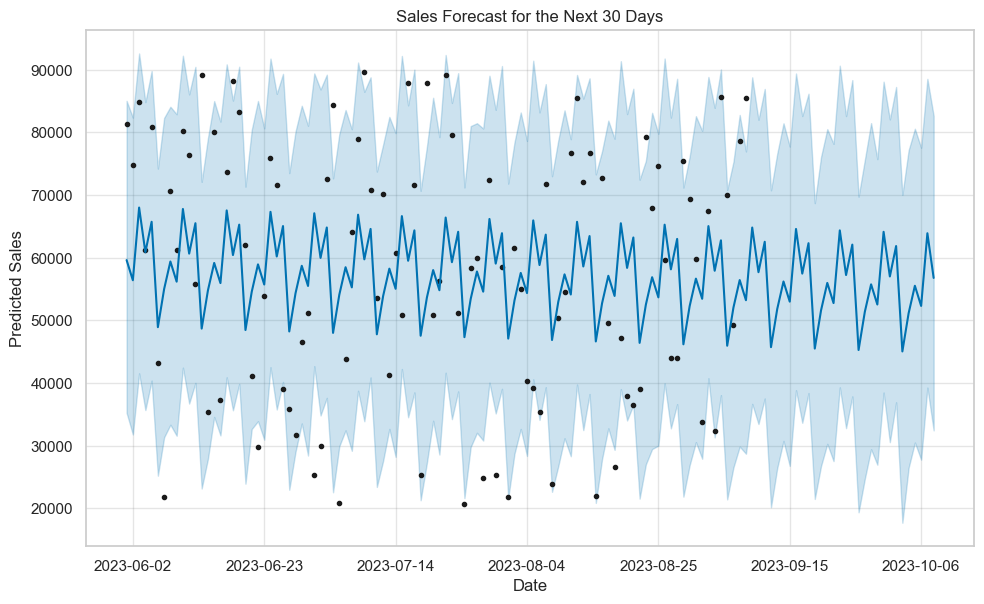

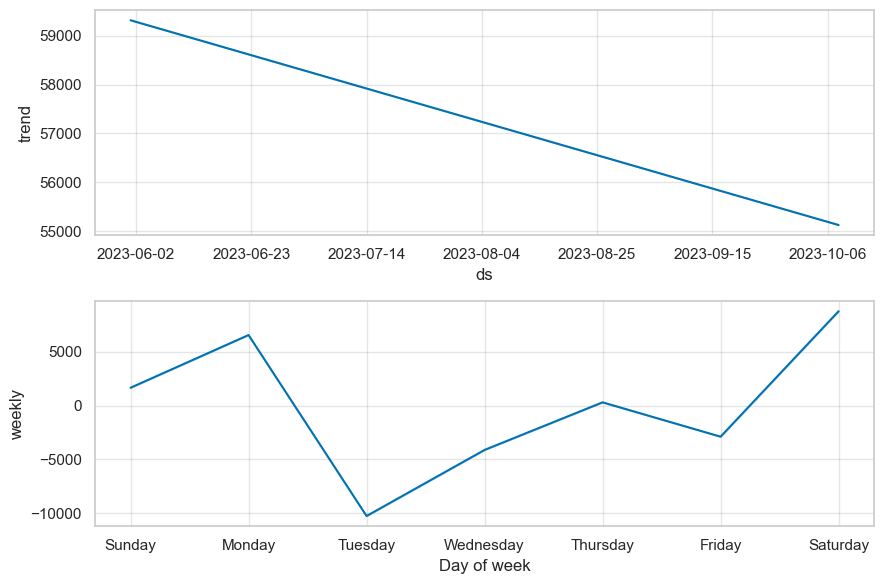

In [25]:
# Model Training & Evaluation
# Sales Forecasting with Prophet

from prophet import Prophet

# Name column names 'ds' (datestamp) and 'y' (value to predict)
prophet_df = daily_summary[['date', 'total_sales']].rename(columns={
    'date': 'ds',
    'total_sales': 'y'
})

# Initialize and fit the model
model = Prophet(daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=False)
model.fit(prophet_df)

# Create a dataframe for future predictions (e.g., 30 days ahead)
future = model.make_future_dataframe(periods=30)

# Make predictions
forecast = model.predict(future)

# Plot the forecast
fig = model.plot(forecast)
plt.title('Sales Forecast for the Next 30 Days')
plt.xlabel('Date')
plt.ylabel('Predicted Sales')
plt.show()

# Plot forecast components (trend, weekly seasonality)
fig2 = model.plot_components(forecast)
plt.show()

In [ ]:
# Data Modeling
# For classification, we will use XGBoost to predict high vs low sales regions.
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Create the 'region_features' DataFrame for the model.
region_features = df.groupby('region').agg(
    total_regional_sales=('regional_sales', 'sum'),
    avg_daily_sales=('regional_sales', 'mean'),
    days_with_sales=('regional_sales', lambda x: (x > 0).sum())
).reset_index()

# To ensure a valid classification problem, a data-driven threshold is required.
# We calculate the median of the total regional sales to split the regions into two performance groups.
sales_median = region_features['total_regional_sales'].median()

print("Diagnostic: Total Sales Per Region")
print(region_features[['region', 'total_regional_sales']].to_string(index=False))
print(f"\nCalculated Median for Threshold: {sales_median:.2f}")

Diagnostic: Total Sales Per Region
region  total_regional_sales
  East              97680.29
 North             118798.80
 South             104648.89
  West             105493.07

Calculated Median for Threshold: 105070.98


In [51]:
# Regions with sales above the median are classified as 'High-Performance' (1),
# and those at or below the median are 'Standard-Performance' (0).
region_features['performance_label'] = region_features['total_regional_sales'].apply(
    lambda x: 1 if x > sales_median else 0
)
print("Engineered Region Features with Data-Driven Target Label:")
print(region_features)

Engineered Region Features with Data-Driven Target Label:
  region  total_regional_sales  avg_daily_sales  days_with_sales  \
0   East              97680.29       322.377195              213   
1  North             118798.80       363.299083              226   
2  South             104648.89       357.163447              204   
3   West             105493.07       339.206013              209   

   performance_label  
0                  0  
1                  1  
2                  0  
3                  1  


In [53]:
# The dataset is separated into the feature matrix (X) and the target vector (y).
X = region_features[['total_regional_sales', 'avg_daily_sales', 'days_with_sales']]
y = region_features['performance_label']
print("Data preparation complete. Features (X) and target (y) are defined.")

Data preparation complete. Features (X) and target (y) are defined.


In [ ]:
# The XGBoost Classifier is initialized
xgb_model = XGBClassifier(eval_metric='logloss')

# The model is trained on the entire feature set (X) and target labels (y).
xgb_model.fit(X, y)
print("Model training complete.")

Model training complete.


In [57]:
# The trained model makes predictions on the same data it was trained on.
# This in-sample evaluation demonstrates the model's ability to learn the patterns in the provided data.
y_pred = xgb_model.predict(X)

# The model's accuracy is calculated by comparing the predicted labels against the original labels.
accuracy = accuracy_score(y, y_pred)
print("Model evaluation complete.")
print(f"\nXGBoost Region Segmentation Model (In-Sample) Accuracy: {accuracy * 100:.2f}%")

Model evaluation complete.

XGBoost Region Segmentation Model (In-Sample) Accuracy: 50.00%


In [ ]:
# Store the Processed Data 

# Save the daily summary data
daily_summary_path = 'daily_summary_processed.csv'
daily_summary.to_csv(daily_summary_path, index=False)
print(f"Daily summary data saved to: {daily_summary_path}")

# Save the region features data
region_features_path = 'region_features_processed.csv'
region_features.to_csv(region_features_path, index=False)
print(f"Region features data saved to: {region_features_path}")

Daily summary data saved to: daily_summary_processed.csv
Region features data saved to: region_features_processed.csv
